# Induktive Statistik & Gruppenvergleiche

**Ziel dieses Notebooks:**

Bisher haben wir die Daten nur beschrieben (Deskriptive Statistik). Wir haben Unterschiede gesehen, wissen aber nicht, ob diese "echt" sind oder nur durch Zufall in unserer Stichprobe entstanden sind. 

Wir wissen nun zum Beispiel, dass der Mittelwert für "Sicherheitsgefühl" bei einem bestimmten Wert liegt. Aber ist dieser Wert verlässlich? Unterscheiden sich Länder mit hoher Kriminalität wirklich signifikant von solchen mit niedriger Kriminalität,

Um das zu beantworten, wenden wir, in diesem Notebook, Methoden der Inferenzstatistik (Vorlesungen 5 bis 9) an, um Hypothesen statistisch zu prüfen. Wir konzentrieren uns dabei besonders auf die Variable "Feeling safe at night" und untersuchen, welche Faktoren dieses Sicherheitsgefühl signifikant beeinflussen.


## 1. Setup & Daten Laden

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from pathlib import Path

In [51]:
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)

## Daten laden & Pivotisieren

Wir nutzen den *Snapshot-Datensatz*, da Hypothesentests unabhängige Beobachtungen erfordern. Zeitreihendaten würden durch die Wiederholung der Länder (Autokorrelation) die p-Werte verfälschen (Pseudoreplikation). Der Snapshot-Datensatz enthält jedes Land genau einmal. Das garantiert die Unabhängigkeit der Datenpunkte.

In [52]:
# Daten laden (robuster Pfad)
base_dir = Path.cwd()
data_file = 'oecd_snapshot_latest.csv'
candidates = [
    base_dir / 'data' / data_file,
    base_dir.parent / 'data' / data_file,
]
data_path = next((p for p in candidates if p.exists()), None)
if data_path is None:
    raise FileNotFoundError(f"Datei nicht gefunden. Versucht wurden: {candidates}")
print(f"Lade Daten von: {data_path}")
df = pd.read_csv(data_path)


Unser Datensatz liegt im "Long Format" vor (eine Zeile pro Messwert). Für statistische Tests, die Zusammenhänge zwischen verschiedenen Variablen prüfen (z.B. Sicherheit vs. Mordrate), brauchen wir das "Wide Format" (eine Zeile pro Land, Variablen als Spalten).

In [53]:
# Wir filtern auf die Gesamtbevölkerung ('Total'), um nur EINEN Wert pro Land und Indikator zu haben.
df_filtered = df_raw[
    (df_raw['age'] == 'Total') & 
    (df_raw['sex'] == 'Total') & 
    (df_raw['education_level'] == 'Total')
].copy()

print(f"Datensätze nach Filterung auf 'Total': {len(df_filtered)}")

# --- DATEN TRANSFORMIEREN (Pivoting) ---
# Jetzt ist die Kombination aus Land (index) und Measure (columns) eindeutig.
df = df_filtered.pivot(index='reference_area', columns='measure', values='value')

# Wir benennen wichtige Spalten um (keine Leerzeichen für einfacheren Code)
df = df.rename(columns={
    'Feeling safe at night': 'FeelingSafe',
    'Life satisfaction': 'LifeSat',
    'Homicides': 'Homicides',
    'Social support': 'SocialSupport',
    'Perceived health as positive': 'Health',
    'Employees working very long hours': 'LongHours'
})

# Wir entfernen Länder, die für unsere Hauptvariable 'FeelingSafe' keine Daten haben
df_clean = df.dropna(subset=['FeelingSafe']).copy()

print(f"Anzahl der Länder in der Analyse: {len(df_clean)}")
# Zeige die ersten Zeilen zur Kontrolle
df_clean[['FeelingSafe', 'Homicides', 'LifeSat', 'SocialSupport']].head()


Datensätze nach Filterung auf 'Total': 2569
Anzahl der Länder in der Analyse: 47


measure,FeelingSafe,Homicides,LifeSat,SocialSupport
reference_area,,,,
Argentina,44.5,3.2,NaN,90.325143
Australia,67.0,0.9,7.2,89.363618
Austria,83.0,0.4,7.6,89.688356
Belgium,71.0,0.7,7.6,90.214418
Brazil,49.5,19.7,NaN,85.987279


# Wahrscheinlichkeit und Verteilungen

Bevor wir komplexe Tests durchführen, müssen wir wissen: Wie sehen unsere Daten eigentlich aus? Viele statistische Standardverfahren (sogenannte parametrische Tests wie der t-Test) funktionieren nur gut, wenn die Daten einer *Normalverteilung* (Glockenkurve) folgen.

Wir nutzen ein *Histogramm* und eine Dichtekurve (Linie), um die Form der Daten zu sehen. Ein *QQ-Plot* hilft uns zusätzlich: Wenn die Punkte auf der roten Linie liegen, sind die Daten normalverteilt.

### Verteilungs-Check: Histogram und QQ-Plot 

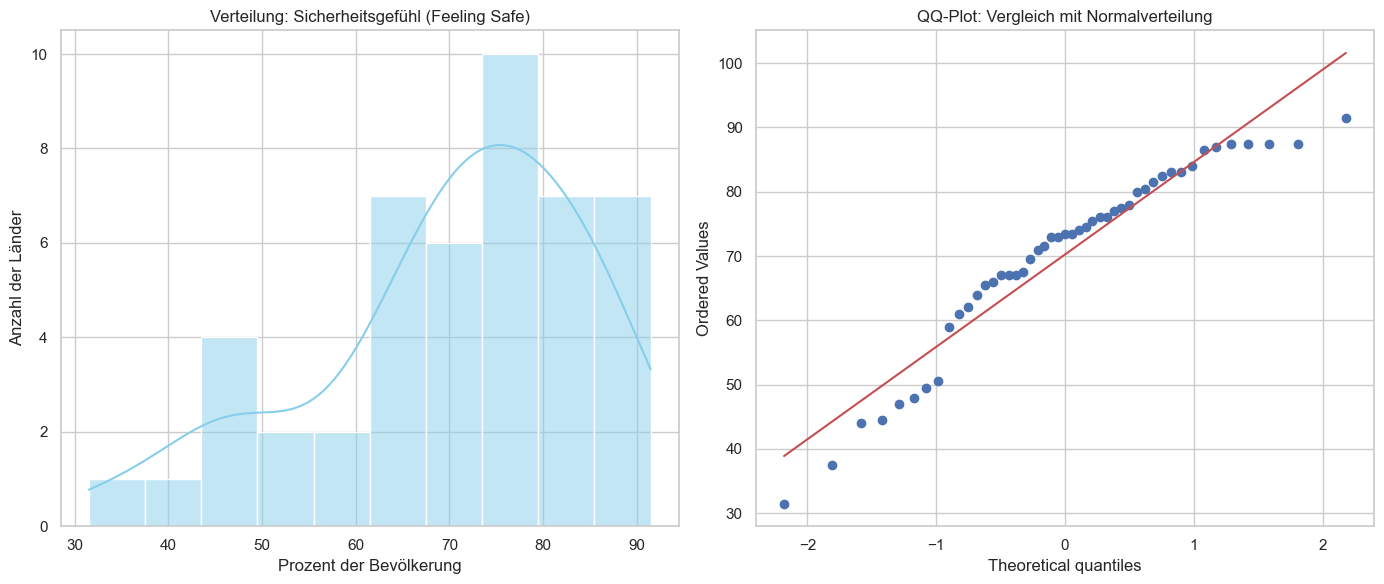

In [54]:
# Verteilungsprüfung

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Histogramm mit Dichtekurve (KDE)
sns.histplot(df_clean['FeelingSafe'], kde=True, color='skyblue', bins=10, ax=axes[0])
axes[0].set_title('Verteilung: Sicherheitsgefühl (Feeling Safe)')
axes[0].set_xlabel('Prozent der Bevölkerung')
axes[0].set_ylabel('Anzahl der Länder')

# 2. QQ-Plot (Quantile-Quantile-Plot)
stats.probplot(df_clean['FeelingSafe'], dist="norm", plot=axes[1])
axes[1].set_title('QQ-Plot: Vergleich mit Normalverteilung')

plt.tight_layout()
plt.show()

### Analyse:

**Histogram:**
- zeigt keine perfekte Glockenkurve (Normalverteilung). Daten sind leicht linksschief. 
- Es gibt keine extreme bimodale Verteilung (zwei Gipfel), aber die Form weicht von der theoretischen Ideallinie ab.

**QQ-Plot**
- Im QQ-Plot vergleichen wir unsere Daten (blaue Punkte) mit einer theoretischen Normalverteilung (rote Linie).
- Die Punkte in der Mitte liegen nah an der Linie.
- An den Rändern (Enden) weichen die Punkte jedoch von der roten Linie ab. Das deutet darauf hin, dass die Ränder der Verteilung ("Tails") schwerer oder leichter sind als bei einer perfekten Normalverteilung. Dies ist ein klassisches Zeichen dafür, dass die Daten nicht strikt normalverteilt sind.



**And now what?**

Da die visuelle Prüfung Zweifel an der perfekten Normalverteilung aufkommen lässt, ist das Ergebnis des folgenden Shapiro-Wilk-Tests entscheidend. Sollte dieser signifikant sein (p<0.05), müssen wir davon ausgehen, dass keine Normalverteilung vorliegt. In diesem Fall ist es methodisch sicherer, für Gruppenvergleiche neben dem t-Test auch nicht-parametrische Tests (wie den Mann-Whitney U-Test) zu verwenden, da diese keine Normalverteilung voraussetzen und robuster gegenüber Ausreißern sind.

### Formaler Test: Shapiro-Wilk

Bilder sind gut, Zahlen sind besser. Der Shapiro-Wilk-Test prüft mathematisch auf Normalverteilung.

- Nullhypothese (H 0): Die Daten sind normalverteilt.

- Gegenhypothese (H 1): Die Daten sind NICHT normalverteilt.

- Entscheidungsregel: Wenn der p-Wert < 0.05 ist, verwerfen wir die Normalverteilung.

In [55]:
# Shapiro-Wilk

stat, p_value = stats.shapiro(df_clean['FeelingSafe'])

print(f"Shapiro-Wilk Test für 'FeelingSafe':")
print(f"Teststatistik: {stat:.4f}")
print(f"p-Wert:        {p_value:.4f}")

print("\n--- INTERPRETATION ---")
if p_value > 0.05:
    print("Der p-Wert ist größer als 0.05.")
    print("Ergebnis: Wir behalten die Nullhypothese bei.")
    print("Bedeutung: Wir können davon ausgehen, dass das Sicherheitsgefühl normalverteilt ist.")
    print("Konsequenz: Wir dürfen parametrische Tests (z.B. t-Test) verwenden.")
else:
    print("Der p-Wert ist kleiner als 0.05.")
    print("Ergebnis: Wir verwerfen die Nullhypothese.")
    print("Bedeutung: Die Daten weichen signifikant von der Normalverteilung ab.")
    print("Konsequenz: Wir sollten robuste, nicht-parametrische Tests (z.B. Mann-Whitney U) bevorzugen.")

Shapiro-Wilk Test für 'FeelingSafe':
Teststatistik: 0.9256
p-Wert:        0.0053

--- INTERPRETATION ---
Der p-Wert ist kleiner als 0.05.
Ergebnis: Wir verwerfen die Nullhypothese.
Bedeutung: Die Daten weichen signifikant von der Normalverteilung ab.
Konsequenz: Wir sollten robuste, nicht-parametrische Tests (z.B. Mann-Whitney U) bevorzugen.


## Punktschätzung und Konfidenzintervalle

Bevor wir Gruppen vergleichen, schauen wir uns die Genauigkeit unserer Messung an.

*Theoretischer Hintergrund*

- **Punktschätzer:** Ein einzelner Wert (z. B. der Mittelwert), der den wahren Parameter der Population (μ) schätzen soll.

- **Konfidenzintervall (Vertrauensbereich):** Da unsere Stichprobe (ca. 38 OECD-Länder) nie exakt den wahren Welt-Durchschnitt abbildet, berechnen wir einen Bereich. Ein 95%-Konfidenzintervall bedeutet: Wenn wir unendlich viele Stichproben ziehen würden, läge der wahre Wert in 95% der Fälle innerhalb dieses Intervalls.

- **Standardfehler (SEM):** Gibt an, wie stark der Stichprobenmittelwert streut.


Anwendung auf den Datensatz: Wir visualisieren das Sicherheitsgefühl mit einem Fehlerbalken. Das zeigt uns sofort, wie "unsicher" unsere Schätzung ist.

--- Schätzung für die Population (OECD & Partner) ---
Punktschätzer (Mittelwert): 70.24%
95% Konfidenzintervall:     [65.99%  bis  74.50%]
Standardfehler (SEM):       2.12


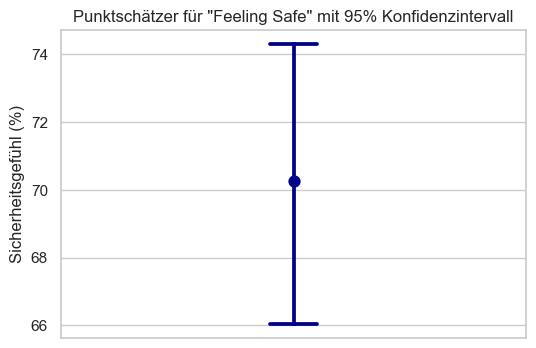

In [56]:
# Punktschätzung und Konfidenzintervalle

# 1. Punktschätzer (Mittelwert)
mean_val = df_clean['FeelingSafe'].mean()

# 2. Standardfehler (SEM - Standard Error of the Mean)
# SEM = Standardabweichung / Wurzel(n)
sem_val = stats.sem(df_clean['FeelingSafe'])

# 3. 95% Konfidenzintervall berechnen
# Wir nutzen die t-Verteilung (da wir die wahre Standardabweichung der Population nicht kennen)
# scale = Standardfehler
ci_low, ci_high = stats.t.interval(confidence=0.95, df=len(df_clean)-1, loc=mean_val, scale=sem_val)

print(f"--- Schätzung für die Population (OECD & Partner) ---")
print(f"Punktschätzer (Mittelwert): {mean_val:.2f}%")
print(f"95% Konfidenzintervall:     [{ci_low:.2f}%  bis  {ci_high:.2f}%]")
print(f"Standardfehler (SEM):       {sem_val:.2f}")

# Visualisierung
plt.figure(figsize=(6, 4))
sns.pointplot(y=df_clean['FeelingSafe'], capsize=.1, errorbar=('ci', 95), color='darkblue')
plt.title('Punktschätzer für "Feeling Safe" mit 95% Konfidenzintervall')
plt.ylabel('Sicherheitsgefühl (%)')
plt.show()

Erklärung zum Code: Der Punkt im Plot ist der Mittelwert. Der Strich (Fehlerbalken) ist das Konfidenzintervall. Je länger der Strich, desto unsicherer ist unsere Schätzung (z. B. weil die Länder sehr unterschiedlich sind).

## Hypothesentests (Vergleich von zwei Gruppen)

Hier kommt die Reaktion auf dein Shapiro-Wilk-Ergebnis, welches wir vorhin berechnet haben. Wir wollen prüfen, ob objektive Sicherheit (Mordrate) das subjektive Gefühl beeinflusst.


**Theoretischer Hintergrund**

- *Nullhypothese (H 0):* Es gibt keinen Unterschied zwischen den Gruppen (Mittelwerte sind gleich).

- *Gegenhypothese (H 1):* Es gibt einen Unterschied.

- *t-Test (unabhängig):* Der Standardtest für Mittelwertvergleiche. Setzt eigentlich Normalverteilung voraus.

- *Mann-Whitney U-Test:* Die nicht-parametrische Alternative. Er vergleicht Ränge (wer ist "größer") statt Mittelwerte. Er ist robuster gegen Ausreißer und schiefe Verteilungen.



**Entscheidung für unseren Datensatz:**

Da dein Shapiro-Wilk-Test gezeigt hat, dass FeelingSafe nicht normalverteilt ist, ist der Mann-Whitney U-Test methodisch korrekter. Wir führen trotzdem beide durch, um zu sehen, ob sie zum gleichen Ergebnis kommen (Robustheitscheck).

**Was wir NICHT machen (und warum):**

- *Gepaarter t-Test:* Dieser wäre nur sinnvoll, wenn wir dasselbe Land zu zwei Zeitpunkten vergleichen würden (Vorher-Nachher). Da wir hier verschiedene Länder in zwei Gruppen (Sicher vs. Unsicher) vergleichen, sind die Stichproben unabhängig.

- *Z-Test*: Dieser setzt voraus, dass wir die Varianz der Grundgesamtheit kennen (was in der Realität nie der Fall ist). Der t-Test ist hier die korrekte Wahl für die Stichprobe.

Anzahl Länder (Low Homicide):  24
Anzahl Länder (High Homicide): 23
Mittelwert 'Feeling Safe' (Low):  76.42%
Mittelwert 'Feeling Safe' (High): 63.80%

--- Testergebnisse ---
Mann-Whitney U-Test (Robust): p = 0.00828
t-Test (Parametrisch):        p = 0.00293

--- Entscheidung (Alpha = 0.05) ---
ERGEBNIS: Signifikant! Wir verwerfen die Nullhypothese.
Interpretation: Die objektive Mordrate hat einen signifikanten Einfluss auf das Sicherheitsgefühl.
Menschen in Ländern mit weniger Morden fühlen sich tatsächlich sicherer.


/var/folders/dz/832hrd_95rn7bh82j0wx55ym0000gn/T/ipykernel_95702/3298678041.py:51: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='Safety_Group', y='FeelingSafe', palette='Pastel1')


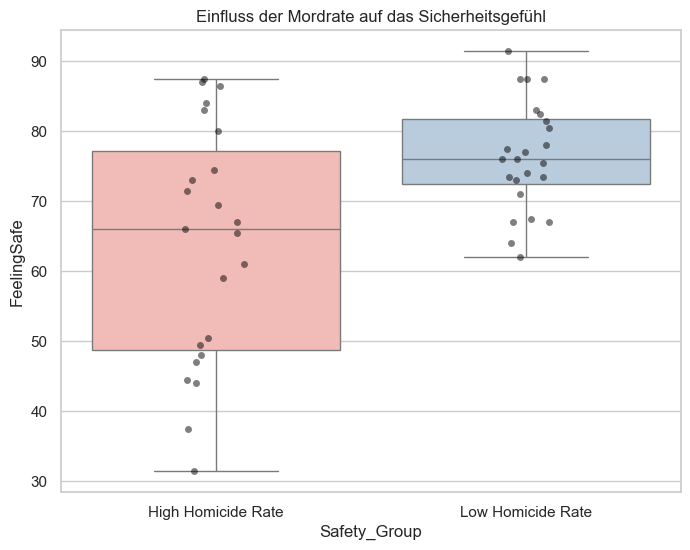

In [57]:
# Gruppenvergleiche (2 Gruppen) 

# SCHRITT 1: Gruppen bilden
# Wir teilen die Länder anhand der Mordrate ('Homicides') in zwei Gruppen.
# Median-Split: Länder unter dem Median sind "Low Homicide", darüber "High Homicide".
median_homicide = df_clean['Homicides'].median()

# Neue Spalte erstellen
df_clean['Safety_Group'] = np.where(
    df_clean['Homicides'] <= median_homicide,
    'Low Homicide Rate',  # Gruppe 1
    'High Homicide Rate'  # Gruppe 2
)

# Daten für die beiden Gruppen extrahieren
group_low = df_clean[df_clean['Safety_Group'] == 'Low Homicide Rate']['FeelingSafe']
group_high = df_clean[df_clean['Safety_Group'] == 'High Homicide Rate']['FeelingSafe']

print(f"Anzahl Länder (Low Homicide):  {len(group_low)}")
print(f"Anzahl Länder (High Homicide): {len(group_high)}")
print(f"Mittelwert 'Feeling Safe' (Low):  {group_low.mean():.2f}%")
print(f"Mittelwert 'Feeling Safe' (High): {group_high.mean():.2f}%")

# SCHRITT 2: Hypothesentests

# A) Mann-Whitney U-Test (Die erste Wahl wegen fehlender Normalverteilung!)
# H0: Die Verteilungen beider Gruppen sind gleich.
u_stat, p_val_u = stats.mannwhitneyu(group_low, group_high, alternative='two-sided')

# B) t-Test für unabhängige Stichproben (Zum Vergleich)
# Wir nutzen equal_var=False (Welch-Test), da wir nicht annehmen können, dass die Varianzen gleich sind.
t_stat, p_val_t = stats.ttest_ind(group_low, group_high, equal_var=False)

print(f"\n--- Testergebnisse ---")
print(f"Mann-Whitney U-Test (Robust): p = {p_val_u:.5f}")
print(f"t-Test (Parametrisch):        p = {p_val_t:.5f}")

# SCHRITT 3: Entscheidung
alpha = 0.05
print(f"\n--- Entscheidung (Alpha = {alpha}) ---")

if p_val_u < alpha:
    print("ERGEBNIS: Signifikant! Wir verwerfen die Nullhypothese.")
    print("Interpretation: Die objektive Mordrate hat einen signifikanten Einfluss auf das Sicherheitsgefühl.")
    print("Menschen in Ländern mit weniger Morden fühlen sich tatsächlich sicherer.")
else:
    print("ERGEBNIS: Nicht signifikant. Wir können H0 nicht verwerfen.")

# Visualisierung
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_clean, x='Safety_Group', y='FeelingSafe', palette='Pastel1')
sns.stripplot(data=df_clean, x='Safety_Group', y='FeelingSafe', color='black', alpha=0.5) # Zeigt die einzelnen Punkte
plt.title('Einfluss der Mordrate auf das Sicherheitsgefühl')
plt.show()

## Mehrgruppenvergleiche (ANOVA & Kruskal-Wallis)

Oft ist die Welt nicht schwarz-weiß. Wir wollen wissen, ob soziale Unterstützung ("Social Support") das Sicherheitsgefühl beeinflusst. Aber Unterstützung ist nicht nur "hoch" oder "niedrig", sondern abgestuft.

**Theoretischer Hintergrund**

- *Problem:* Wenn wir 3 Gruppen haben (Niedrig, Mittel, Hoch) und wir würden 3 t-Tests rechnen (A vs B, B vs C, A vs C), steigt unser Risiko für einen Fehler 1. Art (falsch-positiv) drastisch an (Alpha-Fehler-Kumulierung).

- *Lösung:* Die Varianzanalyse (ANOVA) prüft in einem Schritt, ob es irgendeinen Unterschied gibt.

- *Kruskal-Wallis-Test:* Das ist die nicht-parametrische Alternative zur ANOVA. Da unsere Daten (laut Shapiro-Wilk) nicht normalverteilt sind, ist dieser Test theoretisch sauberer.

- *Post-Hoc Tests:* Wenn die ANOVA/Kruskal-Wallis signifikant ist, wissen wir nur "irgendwer unterscheidet sich". Post-Hoc Tests (wie Tukey oder Dunn) zeigen uns, wer genau anders ist.

**Anwendung auf den Datensatz:**
 Wir teilen die Variable SocialSupport in drei Terzile (Low, Medium, High) und vergleichen das Sicherheitsgefühl.

Mittelwerte Feeling Safe nach Support-Level:
Support_Level
Low Support       63.093750
Medium Support    69.466667
High Support      78.125000
Name: FeelingSafe, dtype: float64

--- Testergebnisse ---
Kruskal-Wallis Test: p = 0.01324
ANOVA (Standard):    p = 0.01022

--- Post-Hoc Analyse (Tukey HSD) ---
Da wir einen signifikanten Unterschied gefunden haben, prüfen wir nun, WELCHE Gruppen sich unterscheiden.


/var/folders/dz/832hrd_95rn7bh82j0wx55ym0000gn/T/ipykernel_95702/142015770.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_val_anova = anova_table['PR(>F)'][0]
/var/folders/dz/832hrd_95rn7bh82j0wx55ym0000gn/T/ipykernel_95702/142015770.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_clean, x='Support_Level', y='FeelingSafe', palette='Set2')


        Multiple Comparison of Means - Tukey HSD, FWER=0.05        
   group1        group2     meandiff p-adj   lower    upper  reject
-------------------------------------------------------------------
High Support    Low Support -15.0312 0.0074 -26.4935  -3.569   True
High Support Medium Support  -8.6583 0.1806   -20.31  2.9933  False
 Low Support Medium Support   6.3729 0.3882  -5.2788 18.0246  False
-------------------------------------------------------------------


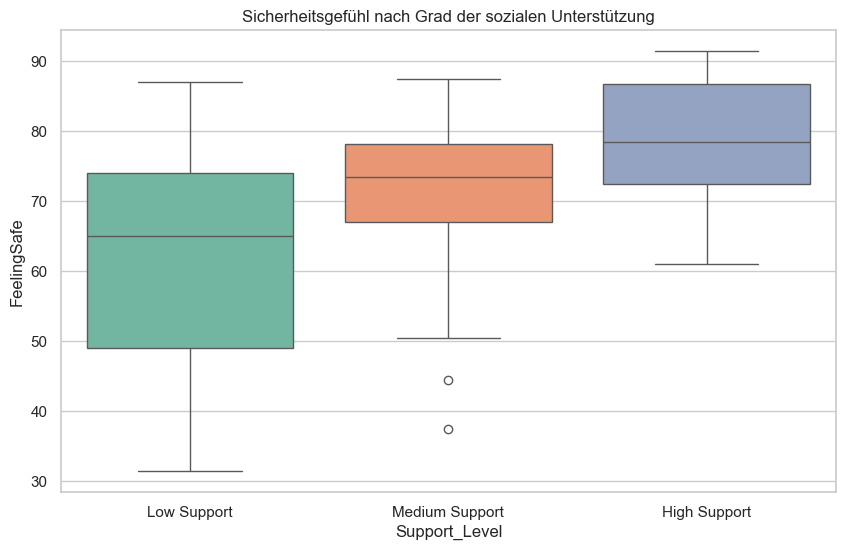

In [58]:
# Mehr als 2 Gruppen 

# 1. Gruppenbildung (Terzile)
# Wir teilen 'Social Support' in 3 gleich große Gruppen
df_clean['Support_Level'] = pd.qcut(df_clean['SocialSupport'], q=3, labels=['Low Support', 'Medium Support', 'High Support'])

print("Mittelwerte Feeling Safe nach Support-Level:")
print(df_clean.groupby('Support_Level', observed=False)['FeelingSafe'].mean())

# 2. Tests durchführen

# A) Kruskal-Wallis H-Test (Nicht-parametrisch -> Erste Wahl wegen Normalverteilung!)
# H0: Alle Gruppen haben die gleiche Verteilung.
groups = [df_clean[df_clean['Support_Level'] == g]['FeelingSafe'] for g in df_clean['Support_Level'].unique()]
h_stat, p_val_kruskal = stats.kruskal(*groups)

# B) One-Way ANOVA (Parametrisch -> Zum Vergleich)
# H0: Alle Gruppenmittelwerte sind gleich.
model = ols('FeelingSafe ~ C(Support_Level)', data=df_clean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
p_val_anova = anova_table['PR(>F)'][0]

print(f"\n--- Testergebnisse ---")
print(f"Kruskal-Wallis Test: p = {p_val_kruskal:.5f}")
print(f"ANOVA (Standard):    p = {p_val_anova:.5f}")

# 3. Post-Hoc Analyse (Nur wenn signifikant)
if p_val_kruskal < 0.05 or p_val_anova < 0.05:
    print("\n--- Post-Hoc Analyse (Tukey HSD) ---")
    print("Da wir einen signifikanten Unterschied gefunden haben, prüfen wir nun, WELCHE Gruppen sich unterscheiden.")
    
    tukey = pairwise_tukeyhsd(endog=df_clean['FeelingSafe'], groups=df_clean['Support_Level'], alpha=0.05)
    print(tukey)
    
    # Visualisierung
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=df_clean, x='Support_Level', y='FeelingSafe', palette='Set2')
    plt.title('Sicherheitsgefühl nach Grad der sozialen Unterstützung')
    plt.show()
else:
    print("\nKeine signifikanten Unterschiede zwischen den Gruppen gefunden.")

**Interpretation:**

- Wenn der Kruskal-Wallis Test signifikant ist (p<0.05), bestätigst du: "Soziale Unterstützung spielt eine Rolle für das Sicherheitsgefühl."

- Der Tukey-Test zeigt dir dann z.B., dass der Unterschied vor allem zwischen "Low Support" und "High Support" besteht, während die mittlere Gruppe vielleicht gar nicht so anders ist.

- Dass wir den Kruskal-Wallis Test gewählt haben, begründest du mit der Verletzung der Normalverteilungsannahme in Schritt 2. Das zeigt, dass du die Theorie aus VL5 verstanden und korrekt angewendet hast.